In [49]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sn

In [265]:
def binomial_probability(k, N, nu):
    if k > N:
        print("k is larger than N!!")
        print(N, k)
    coeff = (math.factorial(N))/(math.factorial(k)*math.factorial(N-k))
    return coeff*(nu**k)*((1-nu)**(N-k))

def beta_dist(x, a, b):
    norm = (scipy.special.gamma(a+b))/(scipy.special.gamma(a)*scipy.special.gamma(b))
    return norm*(x**(a-1))*((1-x)**(b-1))

def posterior(nu, k, N, c):
    return beta_dist(nu, c + k, c + N-k) 

def posterior_mean(k, N, c):
    return (k + c)/(N + c + c)

def posterior_var(k, N, c):
    return ((N-k+c)*(k+c))/((N+2*c+1)*(N+2*c)**2)

/tmp/ipykernel_33613/3808593898.py:10: RuntimeWarning: divide by zero encountered in power
  return norm*(x**(a-1))*((1-x)**(b-1))


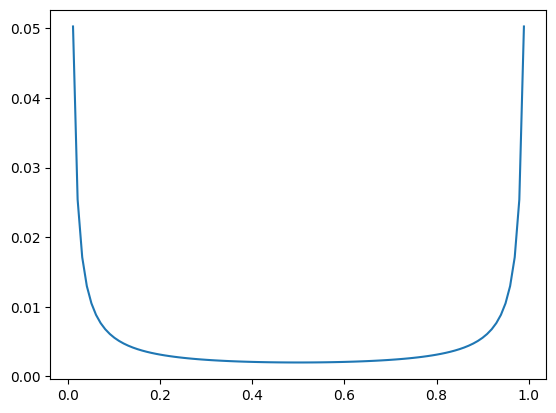

In [266]:
nu_list = np.arange(0, 1, 0.01)
c = 0.001
y_list = beta_dist(nu_list, c, c)
plt.plot(nu_list, y_list)

(1.0000000000000118, 3.674750048339271e-10)


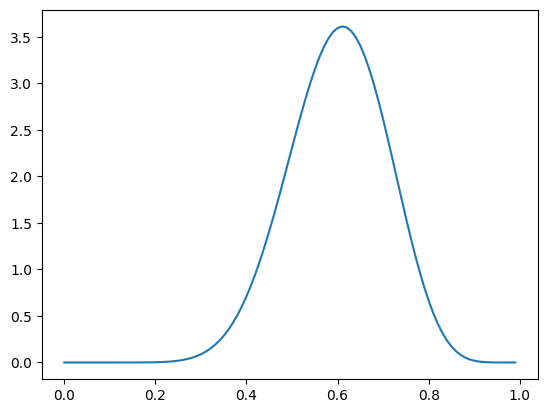

In [264]:
import scipy.integrate as integrate
nu_list = np.arange(0, 1, 0.01)
k = 12
N = 20
c = 0.001
y_list = posterior(nu_list, k, N, c)
plt.plot(nu_list, y_list)
result = integrate.quad(posterior, 0, 1, args=(k,N,c))
print(result)

In [6]:
def weighted_percentile(values, weights, percentile_lower, percentile_upper):
    # Only works for convex distribution
    df = pd.DataFrame({"values":values, "weights":weights})
    df = df.sort_values(by="values")
    percentile_added = 0
    lower_limit_found = False
    upper_limit_found = False
    lower_limit = df["values"].min()
    upper_limit = df["values"].max()
    for i in range(len(df)):
        #Keep lower limit BELOW
        if lower_limit_found == False:
            lower_limit = df["values"][i]
        percentile_added = percentile_added + df["weights"][i]*100
        if (percentile_added >= percentile_lower) and (lower_limit_found == False):
            lower_limit_found = True
            #print("Actual lower limit percentile: ", percentile_added)
        #And upper ABOVE
        if (percentile_added >= percentile_upper) and (upper_limit_found == False):
            upper_limit = df["values"][i]
            upper_limit_found = True
            #print("Actual upper limit percentile: ", percentile_added)
        if upper_limit_found:
            return lower_limit, upper_limit
    return lower_limit, upper_limit


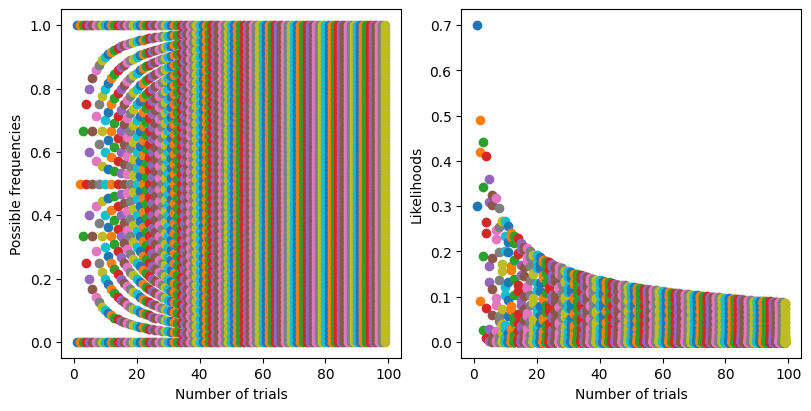

In [18]:
n_list = np.arange(1, 100)
frequencies = [[0]*(n) for n in n_list]
probabilites = [[0]*(n) for n in n_list]
nu=0.3

for i, n in enumerate(n_list):
    k_list = np.arange(0, n+1)
    frequencies[i] = [k/n for k in k_list]
    probabilites[i] = [binomial_probability(k, n, 0.7) for k in k_list]

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8,4), layout="constrained")
for i in range(len(n_list)):
    f_values = frequencies[i]
    axs[0].scatter([n_list[i]]*len(f_values), f_values)
    axs[1].scatter([n_list[i]]*len(probabilites[i]), probabilites[i])
axs[0].set_ylabel("Possible frequencies")
axs[1].set_ylabel("Likelihoods")
for ax in axs:
    ax.set_xlabel("Number of trials")

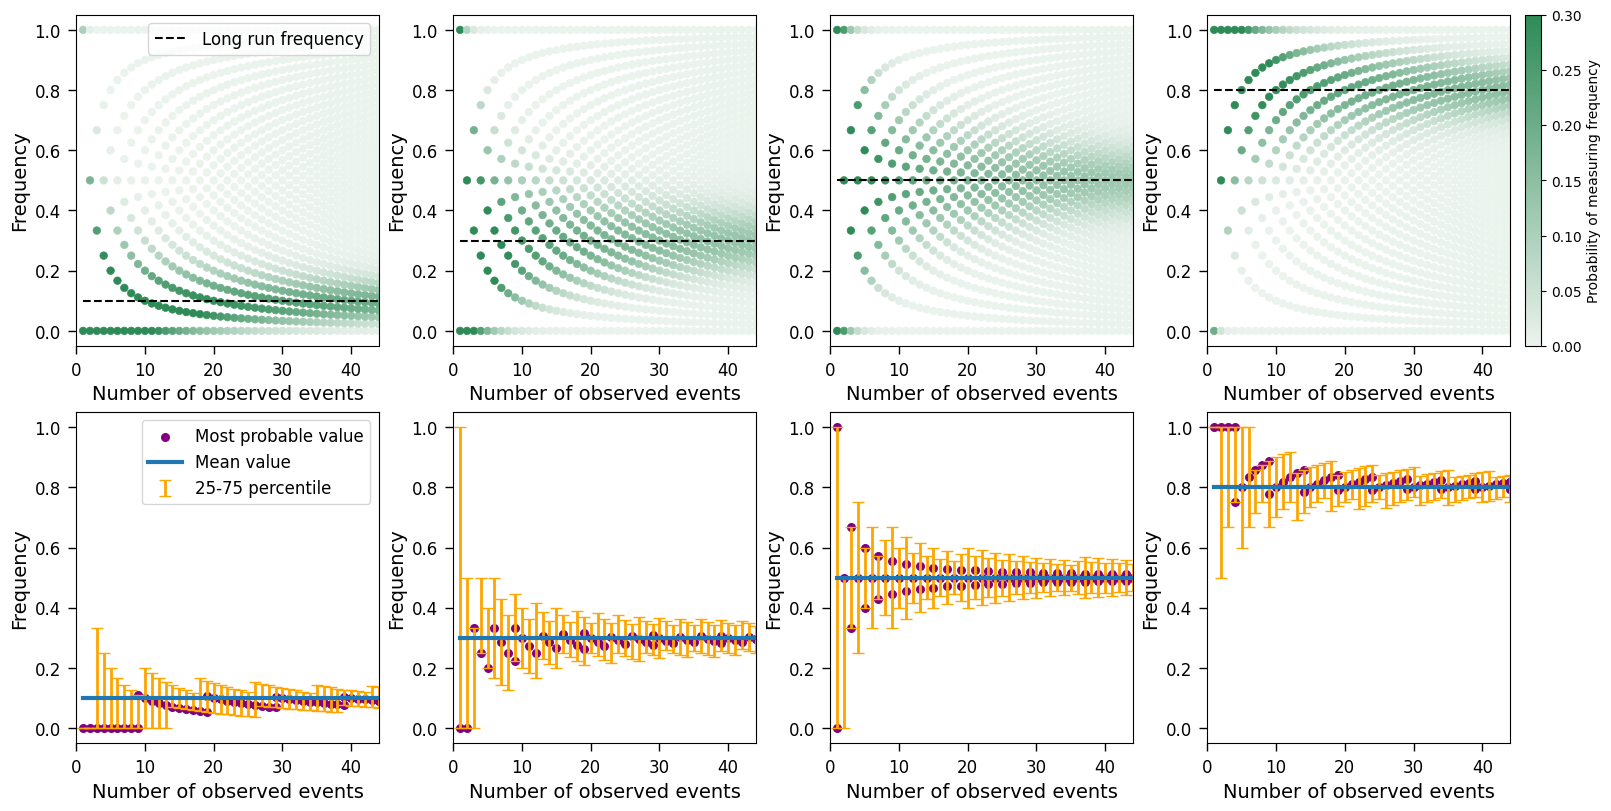

In [16]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(16,8), layout="constrained")

n_list = np.arange(1, 45)
nu_vals = [0.1, 0.3, 0.5, 0.8]
tol = 0.001

for i, nu in enumerate(nu_vals):
    mean_vals = np.zeros(len(n_list))
    #most_prob_vals = np.zeros(len(n_list))
    err_up = np.zeros(len(n_list))
    err_down = np.zeros(len(n_list))
    norm = plt.Normalize(0, 0.3)
    sm = plt.cm.ScalarMappable(cmap=sn.light_palette("seagreen", as_cmap=True), norm=norm)
    for j in range(len(n_list)):
        n = n_list[j]
        k_list = np.arange(0, n+1)
        f_values = np.array([k/n for k in k_list])
        probs = np.array([binomial_probability(k, n, nu) for k in k_list])
        sn.scatterplot(x=[n_list[j]]*len(f_values), y=f_values, hue=probs, s=30, legend=False, ax=axs[0][i], palette=sn.light_palette("seagreen", as_cmap=True), hue_norm=norm, edgecolor='face')
        mean_vals[j] = np.array(f_values*probs).sum()
        #most_prob_vals[j] = f_values[probs.argmax()]
        err_down[j], err_up[j] = weighted_percentile(f_values, probs, 25, 75)
        idx_most_prob = np.where((probs >= probs[np.argmax(probs)] - tol) & (probs <= probs[np.argmax(probs)] + tol))[0]
        axs[1][i].scatter([n]*len(idx_most_prob), f_values[idx_most_prob], s=30, color="purple")
    axs[1][i].scatter([n]*len(idx_most_prob), f_values[idx_most_prob], s=30, label="Most probable value", color="purple")
    axs[0][i].plot([n_list[0], n_list[-1]], [nu, nu], color="black", linestyle="--", label="Long run frequency")
    
    #axs[1][i].scatter(n_list, err_down, label="Approx 25 percentile", color="red", s=10, alpha=0.5, edgecolor="face")
    #axs[1][i].scatter(n_list, err_up, label="Approx 75 percentile", color="blue", s=10, alpha=0.5, edgecolor="face")
    axs[1][i].errorbar(n_list, err_down, yerr=(np.zeros(len(err_down)), np.abs(err_up-err_down)), capsize=4, elinewidth=2, color="orange", label="25-75 percentile", fmt='none')
    axs[1][i].plot(n_list, mean_vals, linewidth=3, label="Mean value")


axs[0][3].figure.colorbar(sm, ax=axs[0][3], label="Probability of measuring frequency")
axs[0][0].legend(loc="upper right", fontsize=12)
axs[1][0].legend(loc="upper right", fontsize=12)
for ax in axs.flatten():
    ax.set_xlabel("Number of observed events", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_ylim(-0.05,1.05)
    ax.set_xlim(n_list[0]-1, n_list[-1])
    ax.tick_params(which="major", direction="out", bottom=True, left=True, pad=5, length=6, width=1, labelsize=12)

#fig.savefig(f"../results/figures/binomial_frequency_distributions.pdf", format="pdf", bbox_inches='tight')


In [110]:
dataset = np.random.binomial(1, 0.4, 0)
print(dataset[0:7].sum())

0


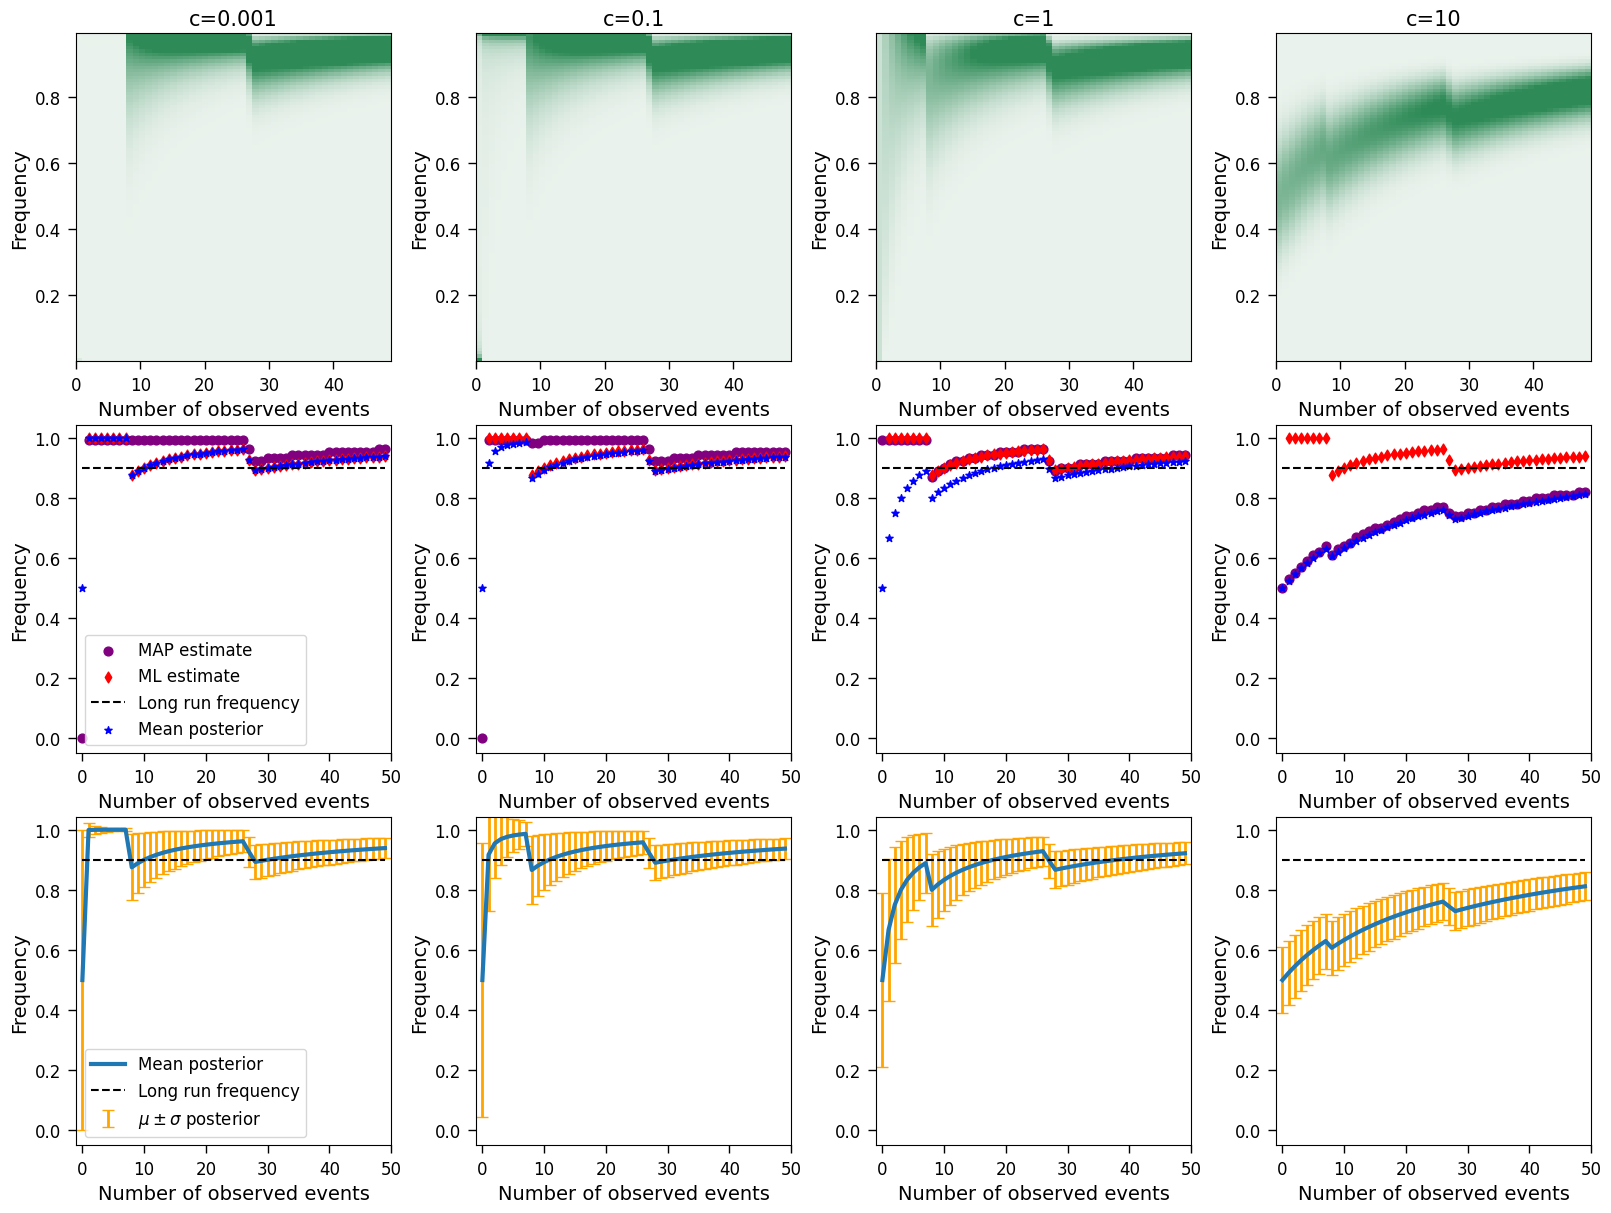

In [254]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(16,12), layout="constrained")
N_max = 50
n_list = np.arange(0, N_max, 1)
nu_list = np.arange(0.001, 1, 0.01)
#nu_lr_vals = [0.1, 0.3, 0.5, 0.8]
nu_lr = 0.9
tol = 0.001
c_prior_vals = [0.001, 0.1, 1, 10]
# Generate a dataset
dataset = np.random.binomial(1, nu_lr, N_max)

for i, c_prior in enumerate(c_prior_vals):
    mean_vals = np.zeros(len(n_list))
    map_vals = np.zeros(len(n_list))
    mle_vals = np.zeros(len(n_list))
    err_up = np.zeros(len(n_list))
    err_down = np.zeros(len(n_list))
    posteriors = np.zeros((len(nu_list), len(n_list)))
    #norm = plt.Normalize(0, 0.2)
    for j in range(len(n_list)):
        n = n_list[j]
        k = dataset[0:n].sum()
        likelihoods = np.array([binomial_probability(k, n, nu) for nu in nu_list])
        posteriors[:,j] = np.flip(posterior(nu_list, k, n, c_prior))
        #sn.scatterplot(x=[n_list[j]]*len(nu_list), y=nu_list, hue=posteriors, s=30, legend=False, ax=axs[0][i], 
        #               palette=sn.light_palette("seagreen", as_cmap=True), edgecolor='face')
        mean_vals[j] = np.array(posterior_mean(k, n , c_prior))
        map_vals[j] = np.flip(nu_list)[posteriors[:,j].argmax()]
        if n > 0:
            mle_vals[j] = k/n
        err_down[j] = np.array(np.sqrt(posterior_var(k, n , c_prior)))
        err_up[j] = np.array(np.sqrt(posterior_var(k, n , c_prior)))
        #err_down[j], err_up[j] = weighted_percentile(nu_list, posteriors, 25, 75)
        #idx_most_prob = np.where((posteriors >= posteriors[np.argmax(posteriors)] - tol) & (posteriors <= posteriors[np.argmax(posteriors)] + tol))[0]
        #axs[1][i].scatter([n]*len(idx_most_prob), f_values[idx_most_prob], s=30, color="purple")
    axs[0][i].imshow(posteriors, aspect="auto", extent=(n_list[0], n_list[-1], nu_list[0], nu_list[-1]), vmin=0, vmax=6, cmap=sn.light_palette("seagreen", as_cmap=True))
    #sn.heatmap(posteriors, ax = axs[0][i], cmap=sn.light_palette("seagreen", as_cmap=True), xticklabels=n_list, yticklabels=nu_list)
    axs[0][i].set_title(f"c={c_prior}", fontsize=15)
    axs[1][i].scatter(n_list, map_vals, s=40, label="MAP estimate", color="purple")
    axs[1][i].scatter(n_list[1:], mle_vals[1:], s=30, label="ML estimate", marker="d", color="red")
    #axs[0][i].plot([n_list[0], n_list[-1]], [nu_lr, nu_lr], color="black", linestyle="--", label="Long run frequency")
    axs[1][i].plot([n_list[0], n_list[-1]], [nu_lr, nu_lr], color="black", linestyle="--", label="Long run frequency")
    axs[1][i].scatter(n_list, mean_vals, s=30, label="Mean posterior", marker="*", color="blue")
    
    #axs[1][i].scatter(n_list, err_down, label="Approx 25 percentile", color="red", s=10, alpha=0.5, edgecolor="face")
    #axs[1][i].scatter(n_list, err_up, label="Approx 75 percentile", color="blue", s=10, alpha=0.5, edgecolor="face")
    axs[2][i].errorbar(n_list, mean_vals, yerr=(err_down), capsize=4, elinewidth=2, color="orange", label=r"$\mu\pm\sigma$ posterior", fmt='none')
    axs[2][i].plot(n_list, mean_vals, linewidth=3, label="Mean posterior")
    axs[2][i].plot([n_list[0], n_list[-1]], [nu_lr, nu_lr], color="black", linestyle="--", label="Long run frequency")

#sm = plt.cm.ScalarMappable(cmap=sn.light_palette("seagreen", as_cmap=True))
#axs[0][3].figure.colorbar(sm, ax=axs[0][3], label="Posterior probability density")
#axs[0][0].legend(loc="lower right", fontsize=12)
axs[1][0].legend(fontsize=12)
axs[2][0].legend(fontsize=12)
for ax in axs[0]:
    ax.set_ylim(nu_list[0], nu_list[-1])
    ax.set_xlim(n_list[0], n_list[-1])
    ax.set_xlabel("Number of observed events", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.tick_params(which="major", direction="out", bottom=True, left=True, pad=5, length=6, width=1, labelsize=12)
for ax in axs[1:].flatten():
    ax.set_xlabel("Number of observed events", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_ylim(nu_list[0]-0.05, nu_list[-1]+0.05)
    ax.set_xlim(n_list[0]-1, n_list[-1]+1)
    ax.tick_params(which="major", direction="out", bottom=True, left=True, pad=5, length=6, width=1, labelsize=12)

fig.savefig(f"../fig/binomial_nu_lr{nu_lr}.pdf", format="pdf", bbox_inches='tight')

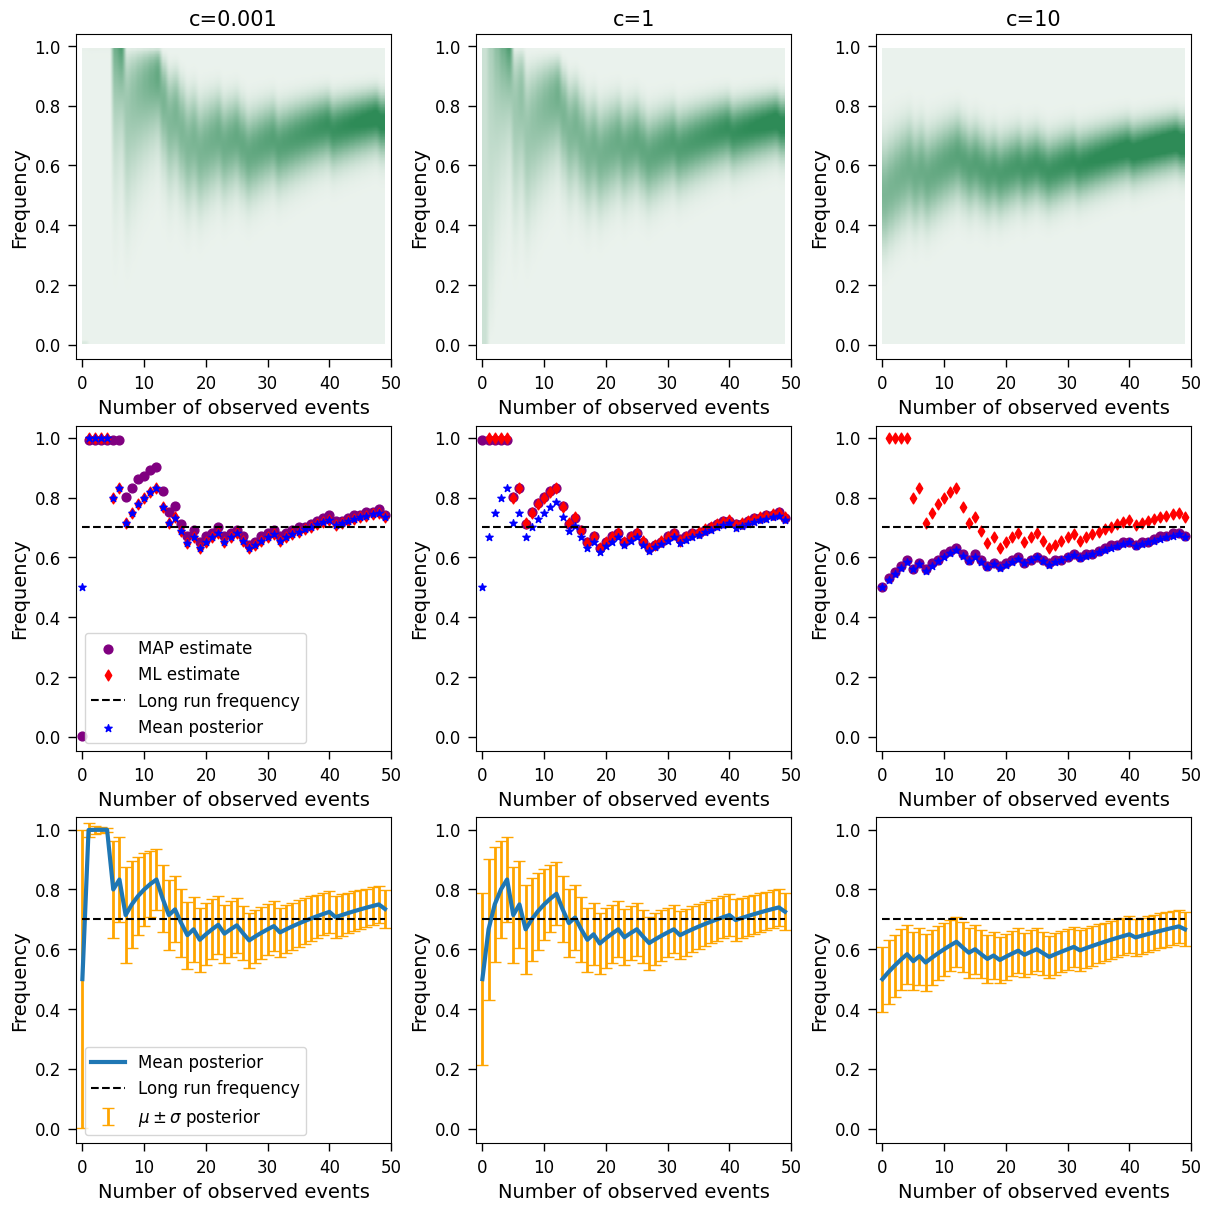

In [267]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12,12), layout="constrained")
N_max = 50
n_list = np.arange(0, N_max, 1)
nu_list = np.arange(0.001, 1, 0.01)
#nu_lr_vals = [0.1, 0.3, 0.5, 0.8]
nu_lr = 0.7
tol = 0.001
c_prior_vals = [0.001, 1, 10]
# Generate a dataset
dataset = np.random.binomial(1, nu_lr, N_max)

for i, c_prior in enumerate(c_prior_vals):
    mean_vals = np.zeros(len(n_list))
    map_vals = np.zeros(len(n_list))
    mle_vals = np.zeros(len(n_list))
    err_up = np.zeros(len(n_list))
    err_down = np.zeros(len(n_list))
    posteriors = np.zeros((len(nu_list), len(n_list)))
    #norm = plt.Normalize(0, 0.2)
    for j in range(len(n_list)):
        n = n_list[j]
        k = dataset[0:n].sum()
        likelihoods = np.array([binomial_probability(k, n, nu) for nu in nu_list])
        posteriors[:,j] = np.flip(posterior(nu_list, k, n, c_prior))
        #sn.scatterplot(x=[n_list[j]]*len(nu_list), y=nu_list, hue=posteriors, s=30, legend=False, ax=axs[0][i], 
        #               palette=sn.light_palette("seagreen", as_cmap=True), edgecolor='face')
        mean_vals[j] = np.array(posterior_mean(k, n , c_prior))
        map_vals[j] = np.flip(nu_list)[posteriors[:,j].argmax()]
        if n > 0:
            mle_vals[j] = k/n
        err_down[j] = np.array(np.sqrt(posterior_var(k, n , c_prior)))
        err_up[j] = np.array(np.sqrt(posterior_var(k, n , c_prior)))
        #err_down[j], err_up[j] = weighted_percentile(nu_list, posteriors, 25, 75)
        #idx_most_prob = np.where((posteriors >= posteriors[np.argmax(posteriors)] - tol) & (posteriors <= posteriors[np.argmax(posteriors)] + tol))[0]
        #axs[1][i].scatter([n]*len(idx_most_prob), f_values[idx_most_prob], s=30, color="purple")
    axs[0][i].imshow(posteriors, aspect="auto", extent=(n_list[0], n_list[-1], nu_list[0], nu_list[-1]), vmin=0, vmax=6, cmap=sn.light_palette("seagreen", as_cmap=True))
    #sn.heatmap(posteriors, ax = axs[0][i], cmap=sn.light_palette("seagreen", as_cmap=True), xticklabels=n_list, yticklabels=nu_list)
    axs[0][i].set_title(f"c={c_prior}", fontsize=15)
    axs[1][i].scatter(n_list, map_vals, s=40, label="MAP estimate", color="purple")
    axs[1][i].scatter(n_list[1:], mle_vals[1:], s=30, label="ML estimate", marker="d", color="red")
    #axs[0][i].plot([n_list[0], n_list[-1]], [nu_lr, nu_lr], color="black", linestyle="--", label="Long run frequency")
    axs[1][i].plot([n_list[0], n_list[-1]], [nu_lr, nu_lr], color="black", linestyle="--", label="Long run frequency")
    axs[1][i].scatter(n_list, mean_vals, s=30, label="Mean posterior", marker="*", color="blue")
    
    #axs[1][i].scatter(n_list, err_down, label="Approx 25 percentile", color="red", s=10, alpha=0.5, edgecolor="face")
    #axs[1][i].scatter(n_list, err_up, label="Approx 75 percentile", color="blue", s=10, alpha=0.5, edgecolor="face")
    axs[2][i].errorbar(n_list, mean_vals, yerr=(err_down), capsize=4, elinewidth=2, color="orange", label=r"$\mu\pm\sigma$ posterior", fmt='none')
    axs[2][i].plot(n_list, mean_vals, linewidth=3, label="Mean posterior")
    axs[2][i].plot([n_list[0], n_list[-1]], [nu_lr, nu_lr], color="black", linestyle="--", label="Long run frequency")

#sm = plt.cm.ScalarMappable(cmap=sn.light_palette("seagreen", as_cmap=True))
#axs[0][3].figure.colorbar(sm, ax=axs[0][3], label="Posterior probability density")
#axs[0][0].legend(loc="lower right", fontsize=12)
axs[1][0].legend(fontsize=12)
axs[2][0].legend(fontsize=12)
for ax in axs[0]:
    ax.set_ylim(nu_list[0], nu_list[-1])
    ax.set_xlim(n_list[0], n_list[-1])
    ax.set_xlabel("Number of observed events", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.tick_params(which="major", direction="out", bottom=True, left=True, pad=5, length=6, width=1, labelsize=12)
for ax in axs[1:].flatten():
    ax.set_xlabel("Number of observed events", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_ylim(nu_list[0]-0.05, nu_list[-1]+0.05)
    ax.set_xlim(n_list[0]-1, n_list[-1]+1)
    ax.tick_params(which="major", direction="out", bottom=True, left=True, pad=5, length=6, width=1, labelsize=12)

fig.savefig(f"../fig/binomial_nu_lr{nu_lr}.pdf", format="pdf", bbox_inches='tight')

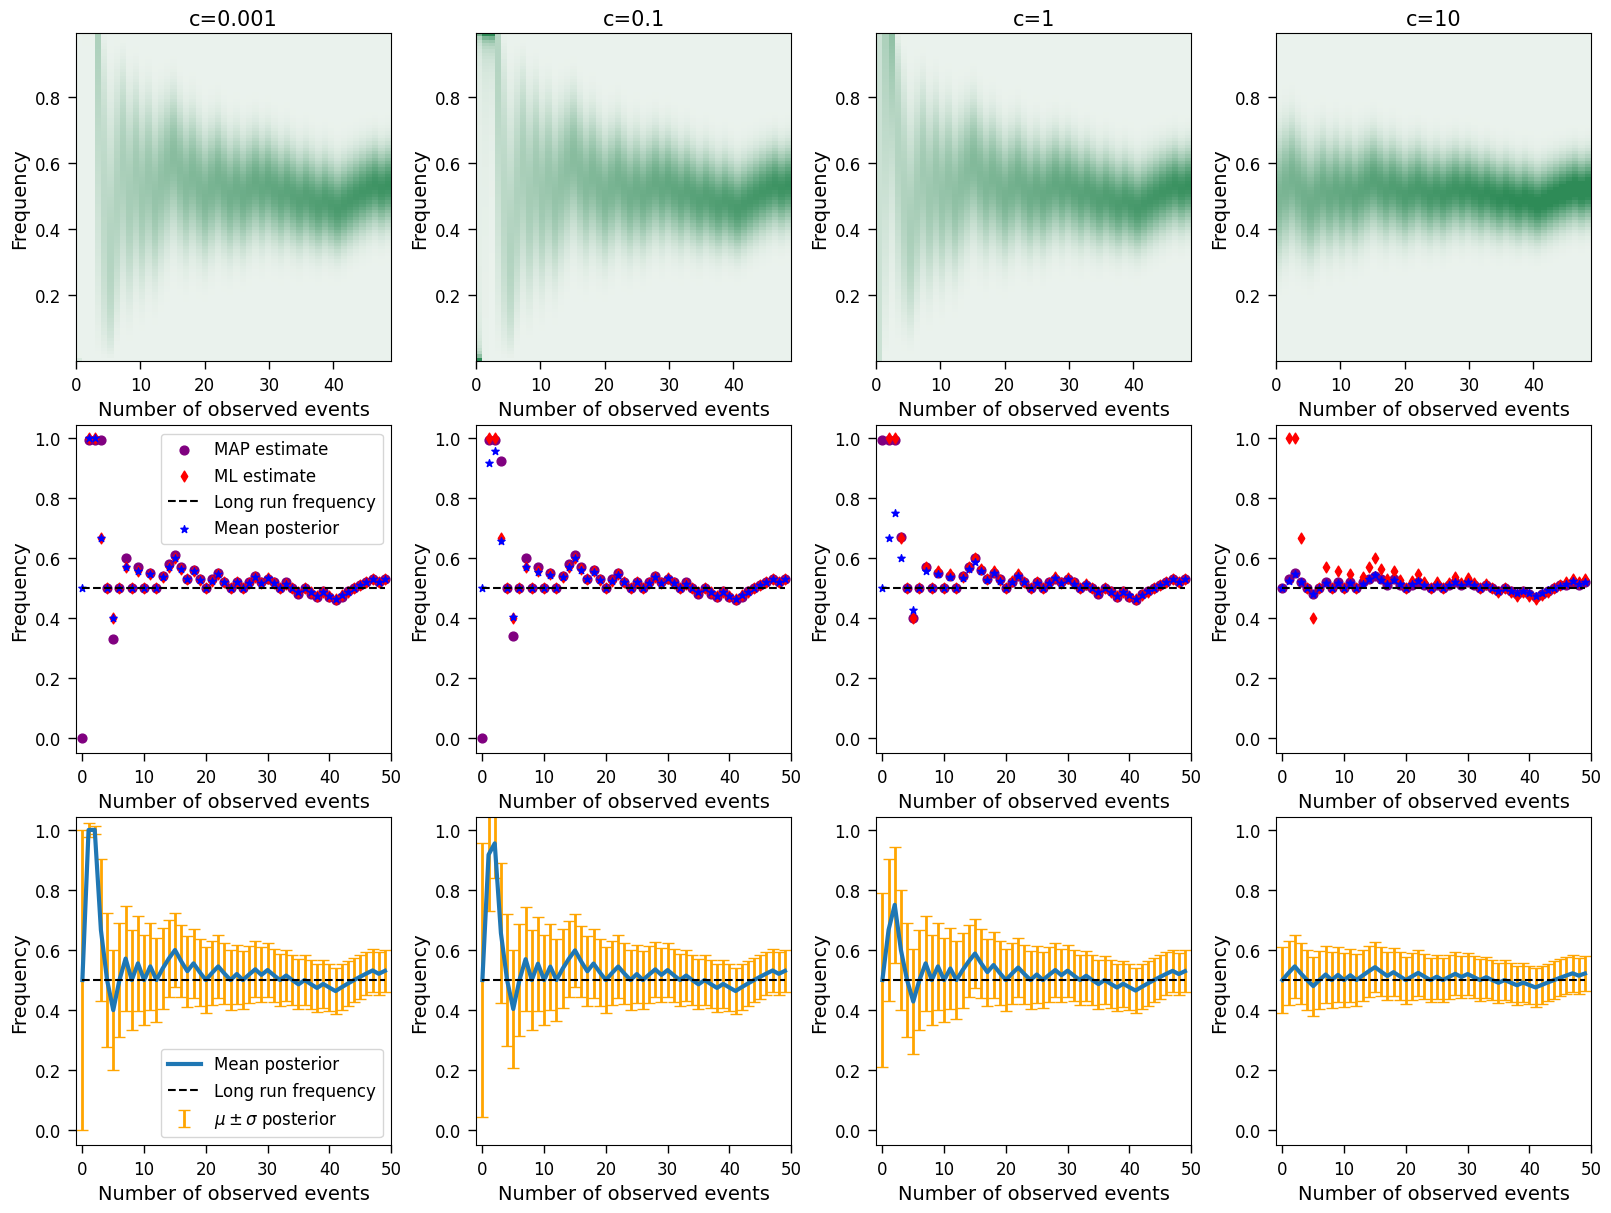

In [256]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(16,12), layout="constrained")
N_max = 50
n_list = np.arange(0, N_max, 1)
nu_list = np.arange(0.001, 1, 0.01)
#nu_lr_vals = [0.1, 0.3, 0.5, 0.8]
nu_lr = 0.5
tol = 0.001
c_prior_vals = [0.001, 0.1, 1, 10]
# Generate a dataset
dataset = np.random.binomial(1, nu_lr, N_max)

for i, c_prior in enumerate(c_prior_vals):
    mean_vals = np.zeros(len(n_list))
    map_vals = np.zeros(len(n_list))
    mle_vals = np.zeros(len(n_list))
    err_up = np.zeros(len(n_list))
    err_down = np.zeros(len(n_list))
    posteriors = np.zeros((len(nu_list), len(n_list)))
    #norm = plt.Normalize(0, 0.2)
    for j in range(len(n_list)):
        n = n_list[j]
        k = dataset[0:n].sum()
        likelihoods = np.array([binomial_probability(k, n, nu) for nu in nu_list])
        posteriors[:,j] = np.flip(posterior(nu_list, k, n, c_prior))
        #sn.scatterplot(x=[n_list[j]]*len(nu_list), y=nu_list, hue=posteriors, s=30, legend=False, ax=axs[0][i], 
        #               palette=sn.light_palette("seagreen", as_cmap=True), edgecolor='face')
        mean_vals[j] = np.array(posterior_mean(k, n , c_prior))
        map_vals[j] = np.flip(nu_list)[posteriors[:,j].argmax()]
        if n > 0:
            mle_vals[j] = k/n
        err_down[j] = np.array(np.sqrt(posterior_var(k, n , c_prior)))
        err_up[j] = np.array(np.sqrt(posterior_var(k, n , c_prior)))
        #err_down[j], err_up[j] = weighted_percentile(nu_list, posteriors, 25, 75)
        #idx_most_prob = np.where((posteriors >= posteriors[np.argmax(posteriors)] - tol) & (posteriors <= posteriors[np.argmax(posteriors)] + tol))[0]
        #axs[1][i].scatter([n]*len(idx_most_prob), f_values[idx_most_prob], s=30, color="purple")
    axs[0][i].imshow(posteriors, aspect="auto", extent=(n_list[0], n_list[-1], nu_list[0], nu_list[-1]), vmin=0, vmax=6, cmap=sn.light_palette("seagreen", as_cmap=True))
    #sn.heatmap(posteriors, ax = axs[0][i], cmap=sn.light_palette("seagreen", as_cmap=True), xticklabels=n_list, yticklabels=nu_list)
    axs[0][i].set_title(f"c={c_prior}", fontsize=15)
    axs[1][i].scatter(n_list, map_vals, s=40, label="MAP estimate", color="purple")
    axs[1][i].scatter(n_list[1:], mle_vals[1:], s=30, label="ML estimate", marker="d", color="red")
    #axs[0][i].plot([n_list[0], n_list[-1]], [nu_lr, nu_lr], color="black", linestyle="--", label="Long run frequency")
    axs[1][i].plot([n_list[0], n_list[-1]], [nu_lr, nu_lr], color="black", linestyle="--", label="Long run frequency")
    axs[1][i].scatter(n_list, mean_vals, s=30, label="Mean posterior", marker="*", color="blue")
    
    #axs[1][i].scatter(n_list, err_down, label="Approx 25 percentile", color="red", s=10, alpha=0.5, edgecolor="face")
    #axs[1][i].scatter(n_list, err_up, label="Approx 75 percentile", color="blue", s=10, alpha=0.5, edgecolor="face")
    axs[2][i].errorbar(n_list, mean_vals, yerr=(err_down), capsize=4, elinewidth=2, color="orange", label=r"$\mu\pm\sigma$ posterior", fmt='none')
    axs[2][i].plot(n_list, mean_vals, linewidth=3, label="Mean posterior")
    axs[2][i].plot([n_list[0], n_list[-1]], [nu_lr, nu_lr], color="black", linestyle="--", label="Long run frequency")

#sm = plt.cm.ScalarMappable(cmap=sn.light_palette("seagreen", as_cmap=True))
#axs[0][3].figure.colorbar(sm, ax=axs[0][3], label="Posterior probability density")
#axs[0][0].legend(loc="lower right", fontsize=12)
axs[1][0].legend(fontsize=12)
axs[2][0].legend(fontsize=12)
for ax in axs[0]:
    ax.set_ylim(nu_list[0], nu_list[-1])
    ax.set_xlim(n_list[0], n_list[-1])
    ax.set_xlabel("Number of observed events", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.tick_params(which="major", direction="out", bottom=True, left=True, pad=5, length=6, width=1, labelsize=12)
for ax in axs[1:].flatten():
    ax.set_xlabel("Number of observed events", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_ylim(nu_list[0]-0.05, nu_list[-1]+0.05)
    ax.set_xlim(n_list[0]-1, n_list[-1]+1)
    ax.tick_params(which="major", direction="out", bottom=True, left=True, pad=5, length=6, width=1, labelsize=12)

fig.savefig(f"../fig/binomial_nu_lr{nu_lr}.pdf", format="pdf", bbox_inches='tight')

In [ ]:
print(likelihoods[0:10])
print(posteriors[0:10])

[0.00000000e+000 3.85376752e-144 7.84079572e-120 1.20789259e-105
 1.33523425e-095 7.90603704e-088 1.71203246e-081 3.77779659e-076
 1.56591872e-071 1.80898155e-067]
[0.00000000e+000 1.30344432e-180 5.25034675e-156 1.20086195e-141
 1.75170296e-131 1.28299283e-123 3.29885234e-117 8.40216750e-112
 3.93748403e-107 5.06162324e-103]
